In [78]:
import os
import math
import datetime
%pip install transformers datasets tensorflow keras

In [79]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as keras

In [80]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
token = 'token'

In [81]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Data Perparation

In [82]:
with open('data_full.json') as json_file:
    data = json.load(json_file)

In [123]:
train = data['train']
test = data['test']
val = data['val']

In [124]:
# Filter the data by valid classes
classes = ['insurance', 'next_holiday', 'repeat', 'credit_limit_change', 'book_hotel',
           'yes', 'damaged_card', 'rewards_balance', 'time', 'pto_balance', 'interest_rate',
           'change_volume', 'taxes', 'sync_device', 'traffic', 'what_song', 'shopping_list',
           'todo_list_update', 'order_checks', 'shopping_list_update']


In [125]:
train_data = [item for item in train if item[1] in classes]
test_data = [item for item in test if item[1] in classes]
val_data = [item for item in val if item[1] in classes]

In [126]:
# Create DataFrames for train, validation, and test datasets
train_df = pd.DataFrame(data=train_data, columns=['text', 'intent'])
val_df = pd.DataFrame(data=val_data, columns=['text', 'intent'])
test_df = pd.DataFrame(data=test_data, columns=['text', 'intent'])

# Data Visualisation

In [127]:
# Display sample data from the training DataFrame
print("Data samples from the training set:")
print(train_df.head())

Data samples from the training set:
                                      text intent
0  what time is it in punta gorda, florida   time
1  what time is it in glenwood springs, co   time
2    what time is it in fredericksburg, tx   time
3         what time is it in las vegas, nv   time
4           what time is it in houston, tx   time


<ipython-input-128-4c53a2cd582a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='intent', palette='viridis')


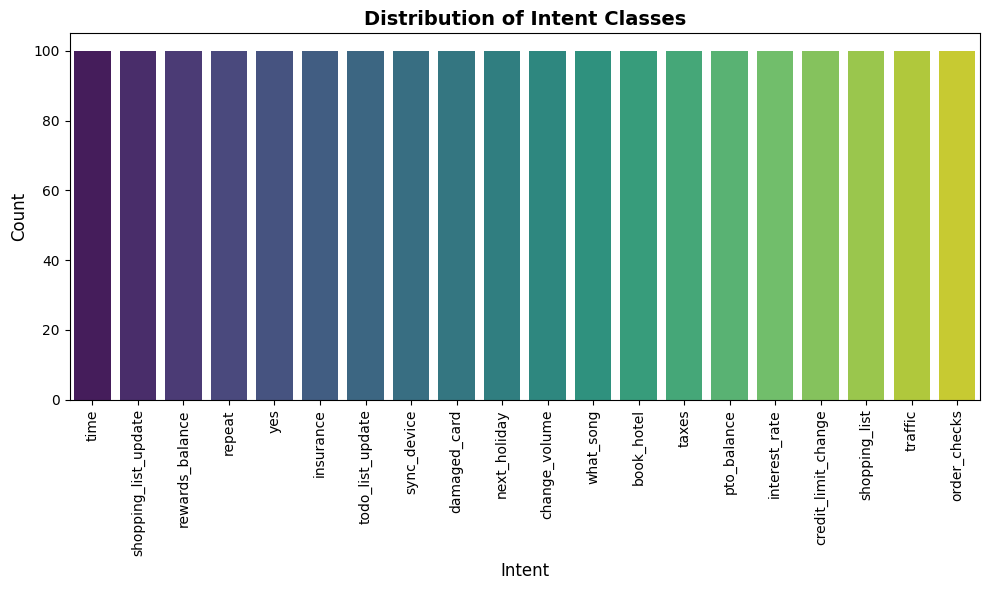

In [128]:
# Visualizing the distribution of intent classes
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='intent', palette='viridis')
plt.xticks(rotation=90, fontsize=10)
plt.title("Distribution of Intent Classes", fontsize=14, weight='bold')
plt.xlabel("Intent", fontsize=12)  # Added a label for the x-axis
plt.ylabel("Count", fontsize=12)  # Added a label for the y-axis
plt.tight_layout()  # Ensures proper spacing
plt.show()

## Data Preprocessing

In [130]:
# Define a function to preprocess text
def preprocess_text(text):
    """Convert text to lowercase."""
    return text.lower()

# Apply preprocessing to the 'text' column in each dataset
for df in [train_df, val_df, test_df]:
    df['text'] = df['text'].apply(preprocess_text)

In [131]:
# Define a function to save DataFrames to CSV
def save_to_csv(df, filename):
    """Save a DataFrame to a CSV file without including the index."""
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Save the train, validation, and test DataFrames
save_to_csv(train_df, 'train_data.csv')
save_to_csv(val_df, 'val_data.csv')
save_to_csv(test_df, 'test_data.csv')

Data saved to train_data.csv
Data saved to val_data.csv
Data saved to test_data.csv


In [132]:
# Function to load CSV files into DataFrames
def load_csv(filename):
    """Load a CSV file into a Pandas DataFrame."""
    print(f"Loading data from {filename}...")
    return pd.read_csv(filename)

# Load the train, validation, and test datasets
train = load_csv('train_data.csv')
valid = load_csv('val_data.csv')
test = load_csv('test_data.csv')

print("Data successfully loaded!")

Loading data from train_data.csv...
Loading data from val_data.csv...
Loading data from test_data.csv...
Data successfully loaded!


## Tokenization Using BERT

In [133]:
from transformers import BertTokenizer

# Load BERT tokenizer from pre-trained model with a custom token (if needed)
def load_tokenizer(model_name='bert-base-uncased', token=None):
    """Load a BERT tokenizer and add custom tokens if provided."""
    tokenizer = BertTokenizer.from_pretrained(model_name)

    if token:
        tokenizer.add_tokens([token])  # Add custom token if provided
        print(f"Custom token '{token}' added to the tokenizer.")

    return tokenizer

# Example usage
tokenizer = load_tokenizer(token='[CUSTOM_TOKEN]')

Custom token '[CUSTOM_TOKEN]' added to the tokenizer.


In [137]:
def tokenize_function(examples):
    return tokenizer(examples['text'].tolist(), padding=True, truncation=True, return_tensors="pt")

In [138]:
train_encodings = tokenize_function(train)
valid_encodings = tokenize_function(valid)
test_encodings = tokenize_function(test)

## Dataset Creation

In [139]:
train_dataset = Dataset.from_dict(train_encodings)
valid_dataset = Dataset.from_dict(valid_encodings)
test_dataset = Dataset.from_dict(test_encodings)

In [140]:
train_dataset = train_dataset.add_column('label', train['intent'].apply(lambda x: classes.index(x)))
valid_dataset = valid_dataset.add_column('label', valid['intent'].apply(lambda x: classes.index(x)))
test_dataset = test_dataset.add_column('label', test['intent'].apply(lambda x: classes.index(x)))

## Model Initialization

In [142]:
from transformers import TFBertForSequenceClassification

# Initialize BERT model for classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(classes),
    use_auth_token=token

)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:3479: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
from transformers import TrainerCallback
from sklearn.metrics import accuracy_score

# Define a function to compute metrics like accuracy
def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Get the most probable predictions
    accuracy = accuracy_score(labels, preds)  # Calculate accuracy
    return {'accuracy': accuracy}  # Return accuracy as a dictionary

# Variables to store training and evaluation losses, and accuracy at each epoch
train_losses = []
eval_losses = []
accuracies = []

# Define a custom callback to log training metrics
class LoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Append the training loss, evaluation loss, and evaluation accuracy if they exist in the logs
            if "train_loss" in logs:
                train_losses.append(logs["train_loss"])
            if "eval_loss" in logs:
                eval_losses.append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                accuracies.append(logs["eval_accuracy"])

## Callbacks and Training Configuration

In [144]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    evaluation_strategy="epoch",     # evaluation strategy (after every epoch)
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,                # log every 10 steps
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [150]:
trainer = Trainer(
    model=model,                         # the model
    args=training_args,                  # training args
    train_dataset=train_dataset,         # training Dataset
    eval_dataset=valid_dataset,          # validation Dataset
    compute_metrics=compute_metrics,     # metrics function
    callbacks=[LoggingCallback]
)

## Model Compilation and Training

In [151]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.077000,0.125956,0.962500
2,0.011300,0.051041,0.992500
3,0.007600,0.052779,0.987500


TrainOutput(global_step=750, training_loss=0.36082620365420975, metrics={'train_runtime': 2729.8072, 'train_samples_per_second': 2.198, 'train_steps_per_second': 0.275, 'total_flos': 89431098768000.0, 'train_loss': 0.36082620365420975, 'epoch': 3.0})

Accuracy and Loss visualisation

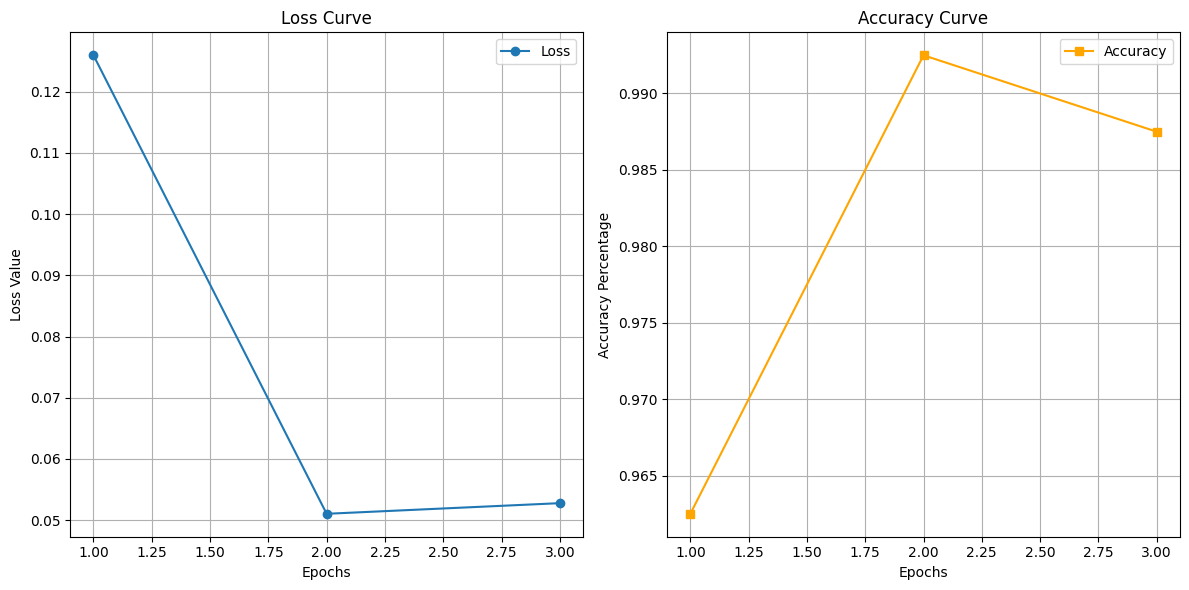

In [152]:
import matplotlib.pyplot as plt

# Prepare epoch data
epochs = range(1, len(eval_losses) + 1)

# Create a figure for the plots
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_losses, linestyle='-', marker='o', label='Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, color='orange', linestyle='-', marker='s', label='Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Percentage')
plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Model evaluation

In [153]:
import numpy as np
import torch

def evaluate_model(trainer, test_dataset):
    """Evaluate the model and print the accuracy."""
    eval_results = trainer.evaluate(test_dataset)
    print(f"Test Accuracy: {eval_results['eval_accuracy']:.2f}")

def get_predictions_with_confidence(trainer, test_dataset):
    """Get predictions and confidence scores from the model."""
    test_preds = trainer.predict(test_dataset)
    probs = torch.nn.functional.softmax(torch.tensor(test_preds.predictions), dim=-1)

    return probs.argmax(axis=-1).numpy(), probs.max(axis=-1).values.numpy() * 100

def display_random_predictions(test_df, pred_labels, confidence_scores, classes, num_samples=10):
    """Display random predictions with their confidence scores."""
    random_indices = np.random.choice(len(test_df), size=num_samples, replace=False)

    for i in random_indices:
        print(f"Texte : {test_df.iloc[i]['text']}")
        print(f"Prédiction de l'intention : {classes[pred_labels[i]]}")
        print(f"Niveau de confiance : {confidence_scores[i]:.2f}%\n")

# Main execution
evaluate_model(trainer, test_dataset)
pred_labels, confidence_scores = get_predictions_with_confidence(trainer, test_dataset)
display_random_predictions(test_df, pred_labels, confidence_scores, classes)

Test Accuracy: 0.99
Texte : i didn't understand you
Prédiction de l'intention : repeat
Niveau de confiance : 99.22%

Texte : what should i squirrel away to pay in taxes
Prédiction de l'intention : taxes
Niveau de confiance : 99.42%

Texte : on the way to work is there traffic
Prédiction de l'intention : traffic
Niveau de confiance : 99.48%

Texte : i need to understand how many points have i earned with my credit card
Prédiction de l'intention : rewards_balance
Niveau de confiance : 99.51%

Texte : i don't need grocery shopping on my todo list anymore
Prédiction de l'intention : todo_list_update
Niveau de confiance : 99.22%

Texte : when will my next vacation day be
Prédiction de l'intention : next_holiday
Niveau de confiance : 99.42%

Texte : what time is it in the greenwich timezone
Prédiction de l'intention : time
Niveau de confiance : 99.46%

Texte : i want the interest rate for my checking account
Prédiction de l'intention : interest_rate
Niveau de confiance : 99.48%

Texte : i mu

Confusion matrix

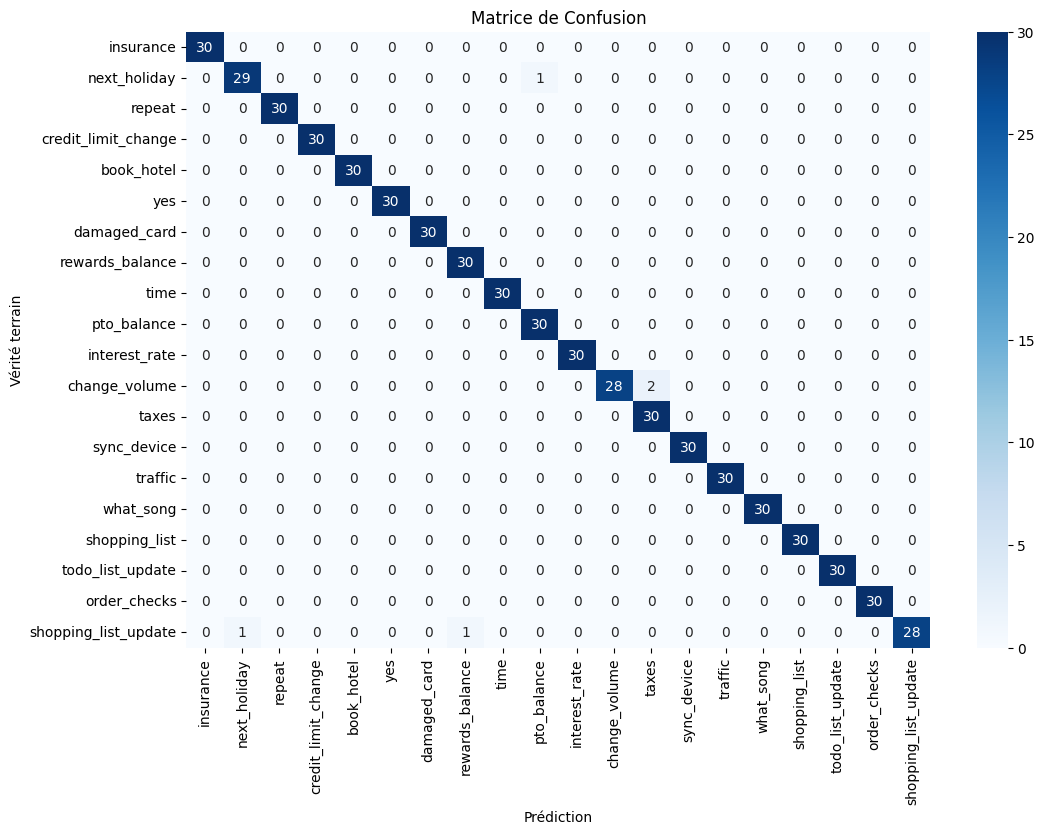

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_intents, pred_labels, classes):
    """Compute and plot the confusion matrix."""
    cm = confusion_matrix(test_intents, [classes[label] for label in pred_labels])

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité terrain')
    plt.title('Matrice de Confusion')
    plt.show()

# Main execution
plot_confusion_matrix(test['intent'], pred_labels, classes)

## Save the model

In [155]:
import pandas as pd

def save_predictions_to_csv(test_df, pred_labels, confidence_scores, classes, filename='predictions_with_confidence.csv'):
    """Create a DataFrame of predictions and save it to a CSV file."""
    results_df = pd.DataFrame({
        'text': test_df['text'],
        'predicted_intent': [classes[label] for label in pred_labels],
        'confidence_score': confidence_scores
    })

    results_df.to_csv(filename, index=False)
    print("Les prédictions et leurs niveaux de confiance ont été sauvegardées.")

# Main execution
save_predictions_to_csv(test_df, pred_labels, confidence_scores, classes)

Les prédictions et leurs niveaux de confiance ont été sauvegardées.


In [156]:
import os

def save_model_and_tokenizer(model, tokenizer, folder='saved_model'):
    """Create a directory and save the model and tokenizer."""
    os.makedirs(folder, exist_ok=True)
    model.save_pretrained(folder)
    tokenizer.save_pretrained(folder)
    print(f"Model and tokenizer have been saved to '{folder}'.")

# Main execution
save_model_and_tokenizer(model, tokenizer)

Model and tokenizer have been saved to 'saved_model'.
